# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

## Answer to the questions:

1. Why the coverage slows down the increase as the vocabulary size increases?

Most of the tokens in the corpus are covered by a very small set of highly frequent words (the, of, and, to, a, and so on). As we continue to expand the vocabulary by including rarer words, each newly added word adds less to the total coverage. Consequently, the growth of cumulative coverage slows down.

2. Which empirical law explains the slowing down increase of the coverage?

This phenomenon is explained by **Zipf’s law**, which states that the frequency of a word is inversely proportional to its rank in the frequency list:

$$f(r) \propto \frac{1}{r}$$

Total tokens in Brown corpus: 1,161,192
Unique words: 56,057
Minimal vocabulary size for >=90% coverage: 8012


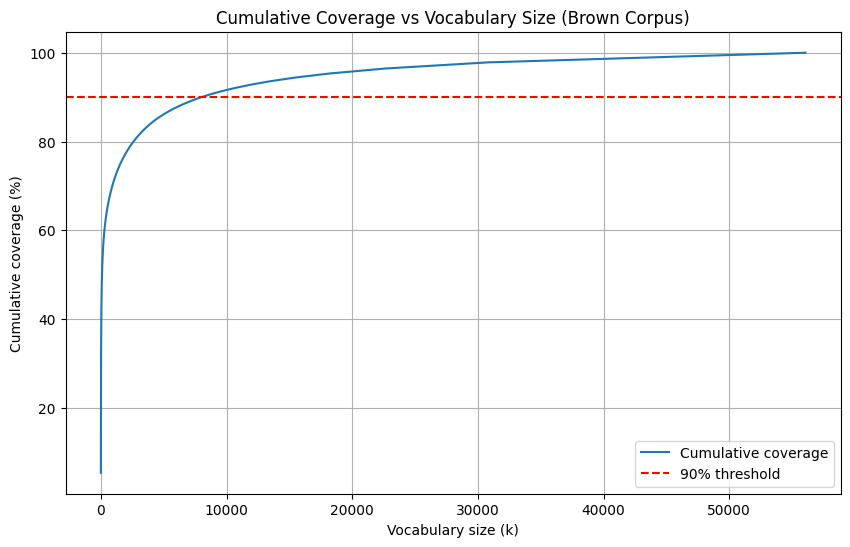

In [5]:
# Import libraries
import nltk
nltk.download('brown', quiet=True)
from nltk.corpus import brown
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Load the Brown corpus
all_words = brown.words()
word_freq = Counter(all_words)

# Sort by frequency descending
sorted_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

total_tokens = sum(word_freq.values())
print(f"Total tokens in Brown corpus: {total_tokens:,}")
print(f"Unique words: {len(word_freq):,}")

# Cumulative coverage
cum_sum = 0
coverages = []
min_vocab_size = None

for rank, (word, freq) in enumerate(sorted_freq, 1):
    cum_sum += freq
    coverage = (cum_sum / total_tokens) * 100
    coverages.append(coverage)
    if coverage >= 90 and min_vocab_size is None:
        min_vocab_size = rank

# This is the size of vocabuklary that covers >= 90% (8012)
print(f"Minimal vocabulary size for >=90% coverage: {min_vocab_size}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(coverages) + 1), coverages, label='Cumulative coverage')
plt.axhline(y=90, color='r', linestyle='--', label='90% threshold')
plt.xlabel('Vocabulary size (k)')
plt.ylabel('Cumulative coverage (%)')
plt.title('Cumulative Coverage vs Vocabulary Size (Brown Corpus)')
plt.legend()
plt.grid(True)
plt.show()

# Save the value for Task 3
appropriate_vocab_size = min_vocab_size

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [8]:
from collections import defaultdict

class BPETokenizer:
    # Byte-Pair Encoding tokenizer implementation. Here I tried to follow the Hugging Face tutorial on BPE referenced in the lab
    def __init__(self):
        self.vocab = None # list of tokens
        self.merges = None # dict: (token1, token2) -> merged_token

    def train(self, corpus: list[str], vocab_size: int):
        # Whitespace split
        word_freqs = defaultdict(int)
        for text in corpus:
            for word in text.split():
                word_freqs[word] += 1

        # Build base vocabulary
        alphabet = []
        for word in word_freqs.keys():
            for char in word:
                if char not in alphabet:
                    alphabet.append(char)
        alphabet.sort()
        self.vocab = ["<|endoftext|>"] + alphabet

        # Split words into lists of characters
        splits = {word: list(word) for word in word_freqs.keys()}

        self.merges = {}

        # Main BPE loop
        while len(self.vocab) < vocab_size:
            # Count pair frequencies
            pair_freqs = defaultdict(int)
            for word, freq in word_freqs.items():
                split = splits[word]
                if len(split) == 1:
                    continue
                for i in range(len(split) - 1):
                    pair = (split[i], split[i + 1])
                    pair_freqs[pair] += freq

            if not pair_freqs:
                break

            # Most frequent pair
            best_pair = max(pair_freqs, key=pair_freqs.get)

            splits = self._merge_pair(best_pair[0], best_pair[1], splits, word_freqs)

            # Save merge rule
            merged_token = best_pair[0] + best_pair[1]
            self.merges[best_pair] = merged_token
            self.vocab.append(merged_token)

        print(f"BPE training finished. Final vocab size: {len(self.vocab)}")

    def _merge_pair(self, a: str, b: str, splits: dict, word_freqs: dict):
        # Replace every occurrence of pair (a, b) with (a+b) in all words
        for word in word_freqs:
            split = splits[word]
            if len(split) == 1:
                continue
            i = 0
            while i < len(split) - 1:
                if split[i] == a and split[i + 1] == b:
                    split = split[:i] + [a + b] + split[i + 2:]
                else:
                    i += 1
            splits[word] = split
        return splits

    def tokenize(self, text: str) -> list[str]:
        # Tokenize a text using learned BPE merges
        pre_tokens = text.split()
        splits = [list(pt) for pt in pre_tokens]

        # Apply merges in the order they were learned
        for pair, merge in self.merges.items():
            for idx in range(len(splits)):
                split = splits[idx]
                i = 0
                while i < len(split) - 1:
                    if split[i] == pair[0] and split[i + 1] == pair[1]:
                        split = split[:i] + [merge] + split[i + 2:]
                    else:
                        i += 1
                splits[idx] = split

        # Flatten
        tokens = []
        for s in splits:
            tokens.extend(s)
        return tokens

## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [9]:
# Train on the full Brown corpus with the size found in Task 1 (8012)
sentences = [' '.join(sent) for sent in brown.sents()]

tokenizer = BPETokenizer()
tokenizer.train(sentences, appropriate_vocab_size)

# Analysis on 1000 samples
samples = [' '.join(sent) for sent in brown.sents()[:1000]]

fertilities = []
token_lengths = []

for text in samples:
    orig_words = len(text.split())
    if orig_words == 0:
        continue
    tokens = tokenizer.tokenize(text)
    tok_len = len(tokens)

    fertility = tok_len / orig_words
    fertilities.append(fertility)
    token_lengths.append(tok_len)

mean_fert = np.mean(fertilities)
std_fert = np.std(fertilities)
mean_len = np.mean(token_lengths)
std_len = np.std(token_lengths)

print(f"Tokenizer fertility (mean ± std): {mean_fert:.4f} ± {std_fert:.4f}")
print(f"Tokenized sentence length (mean ± std): {mean_len:.2f} ± {std_len:.2f}")

BPE training finished. Final vocab size: 8012
Tokenizer fertility (mean ± std): 1.2584 ± 0.2759
Tokenized sentence length (mean ± std): 26.73 ± 14.67


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later.

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.